# ReadmitRisk – 30-Day Hospital Readmission Predictor
## INT234 Predictive Analytics Project

**Project Title:** Patient-Facing Hospital Readmission Risk Calculator  
**Dataset:** UCI Diabetes 130-US Hospitals (101,767 patient records)  
**Target:** Predict if patient will be readmitted within 30 days

---

## Project Overview

This notebook covers **9 practicals** and **CO1-CO6** course outcomes:

- **Practicals 1-2 (CO1):** Data Preprocessing & EDA
- **Practical 3 (CO2):** Regression Models (Simple, Multiple, Logistic)
- **Practicals 4-5 (CO3):** Classification (KNN, Naive Bayes, Decision Tree, SVM)
- **Practicals 6-7 (CO4):** Clustering (K-Means, Hierarchical) & Association Rules
- **Practicals 8-9 (CO6):** Model Validation (Cross-Validation) & Ensembles (Bagging, RF, AdaBoost, XGBoost)

**Final Goal:** Build a patient-facing app where users input health data and receive personalized readmission risk scores.

---

## Section 1: Setup & Imports
### Practical 1-2 | CO1: Data Preprocessing

Import all necessary libraries for data manipulation, visualization, and machine learning.

In [18]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
warnings.filterwarnings('ignore')

# Sklearn - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Sklearn - Regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

# Sklearn - Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Sklearn - Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Sklearn - Ensemble Methods
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    silhouette_score
)

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Model Persistence
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("="*80)
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"NumPy version: {np.__version__}")
print("="*80)

✅ ALL LIBRARIES IMPORTED SUCCESSFULLY!
Pandas version: 2.1.4
Scikit-learn version: 1.3.2
NumPy version: 1.26.2


## Section 2: Data Loading & Initial Exploration
### Practical 1 | CO1: Understanding the Dataset

Load the UCI Diabetes 130-US Hospitals dataset and perform initial exploration.

In [19]:
# Load the dataset
df = pd.read_csv('dataset/diabetic_data.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\n📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\n🎯 Target Variable: 'readmitted' (NO, <30, >30)")
print("\nFirst few rows:")
print(df.head())

print("\n" + "="*80)
print("COLUMN INFORMATION")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("TARGET VARIABLE DISTRIBUTION")
print("="*80)
print(df['readmitted'].value_counts())
print("\nPercentages:")
print(df['readmitted'].value_counts(normalize=True) * 100)

print("\n" + "="*80)
print("SUMMARY STATISTICS (Numeric Columns)")
print("="*80)
print(df.info())

DATASET OVERVIEW

📊 Dataset Shape: 101,766 rows × 50 columns

🎯 Target Variable: 'readmitted' (NO, <30, >30)

First few rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_

In [20]:
# Step 1: Check for missing values (marked as "?")
print("="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

missing_summary = []
for col in df.columns:
    question_marks = (df[col] == '?').sum()
    null_values = df[col].isnull().sum()
    if question_marks > 0 or null_values > 0:
        missing_summary.append({
            'Column': col,
            'Question Marks': question_marks,
            'Null Values': null_values,
            'Total Missing': question_marks + null_values,
            'Percentage': ((question_marks + null_values) / len(df)) * 100
        })

missing_df = pd.DataFrame(missing_summary).sort_values('Total Missing', ascending=False)
print(missing_df.to_string(index=False))


print("\n🔍 Columns with >50% missing data (will be dropped):")
high_missing = missing_df[missing_df['Percentage'] > 50]
print(high_missing['Column'].tolist() if len(high_missing) > 0 else "None")

MISSING VALUES ANALYSIS
           Column  Question Marks  Null Values  Total Missing  Percentage
           weight           98569            0          98569   96.858479
    max_glu_serum               0        96420          96420   94.746772
        A1Cresult               0        84748          84748   83.277322
medical_specialty           49949            0          49949   49.082208
       payer_code           40256            0          40256   39.557416
             race            2273            0           2273    2.233555
           diag_3            1423            0           1423    1.398306
           diag_2             358            0            358    0.351787
           diag_1              21            0             21    0.020636

🔍 Columns with >50% missing data (will be dropped):
['weight', 'max_glu_serum', 'A1Cresult']
           Column  Question Marks  Null Values  Total Missing  Percentage
           weight           98569            0          98569   96.8

In [21]:
# Step 2: COMPREHENSIVE DATA CLEANING
print("="*80)
print("COMPREHENSIVE DATA CLEANING")
print("="*80)

df_clean = df.copy()

# 1. Replace ALL missing value indicators with NaN
print("\n1. Replacing missing value indicators with NaN...")
df_clean = df_clean.replace('?', np.nan)
df_clean = df_clean.replace('', np.nan)
df_clean = df_clean.replace(' ', np.nan)

# 2. Drop identifier columns (not useful for prediction)
print("2. Dropping identifier columns...")
df_clean = df_clean.drop(columns=['encounter_id', 'patient_nbr'], errors='ignore')

# 3. Handle columns with excessive missing data
print("3. Handling sparse columns...")
missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
sparse_cols = missing_pct[missing_pct > 50].index.tolist()
print(f"   Dropping columns with >50% missing: {sparse_cols}")
df_clean = df_clean.drop(columns=sparse_cols, errors='ignore')

# Also drop payer_code and medical_specialty (too many categories and missing values)
df_clean = df_clean.drop(columns=['payer_code', 'medical_specialty'], errors='ignore')

# 4. Clean diagnosis columns (handle V-codes and E-codes, convert to numeric)
print("4. Cleaning diagnosis columns (handling V-codes, E-codes)...")
diag_cols = ['diag_1', 'diag_2', 'diag_3']
for col in diag_cols:
    if col in df_clean.columns:
        # Extract numeric part from codes like "V57", "E123", "250.01"
        df_clean[col] = df_clean[col].astype(str).str.replace('V', '900', regex=False)  # V-codes → 900 series
        df_clean[col] = df_clean[col].str.replace('E', '800', regex=False)  # E-codes → 800 series
        df_clean[col] = df_clean[col].str.split('.').str[0]  # Remove decimal part
        # Convert to numeric, non-numeric becomes NaN
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        # Fill NaN with 0 (no diagnosis)
        df_clean[col] = df_clean[col].fillna(0).astype(int)

# 5. Handle "None" values in lab result columns
print("5. Handling 'None' values in lab results...")
# Keep "None" as a valid category (means test not performed)
# Will be encoded later

# 6. Convert target variable to binary
print("\n6. Converting target variable to binary...")
print("="*80)
print("TARGET VARIABLE TRANSFORMATION")
print("="*80)
print(f"Original distribution:\n{df_clean['readmitted'].value_counts()}\n")

df_clean['readmitted_binary'] = df_clean['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

print(f"Binary distribution:")
print(df_clean['readmitted_binary'].value_counts())
print(f"\nClass Balance:")
print(df_clean['readmitted_binary'].value_counts(normalize=True) * 100)

# Drop original readmitted column
df_clean = df_clean.drop(columns=['readmitted'])

# 7. Clean admission/discharge IDs (ensure numeric)
print("\n7. Cleaning ID columns...")
id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for col in id_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 1)
        df_clean[col] = df_clean[col].astype(int)

# 8. Ensure numeric columns are proper type
print("8. Converting numeric columns to proper types...")
numeric_expected = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                   'num_medications', 'number_diagnoses', 'number_outpatient', 
                   'number_emergency', 'number_inpatient']
for col in numeric_expected:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        df_clean[col] = df_clean[col].astype(int)

# 9. Remove any remaining rows with critical missing values
print("9. Removing rows with critical missing values...")
initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=['readmitted_binary'])
df_clean = df_clean.dropna(subset=['age', 'gender'])  # Critical demographics
final_rows = len(df_clean)
print(f"   Removed {initial_rows - final_rows} rows with critical missing values")

print(f"\n✅ Dataset shape after comprehensive cleaning: {df_clean.shape}")
print(f"✅ Remaining missing values: {df_clean.isnull().sum().sum()}")

COMPREHENSIVE DATA CLEANING

1. Replacing missing value indicators with NaN...
2. Dropping identifier columns...
3. Handling sparse columns...
   Dropping columns with >50% missing: ['weight', 'max_glu_serum', 'A1Cresult']
4. Cleaning diagnosis columns (handling V-codes, E-codes)...
2. Dropping identifier columns...
3. Handling sparse columns...
   Dropping columns with >50% missing: ['weight', 'max_glu_serum', 'A1Cresult']
4. Cleaning diagnosis columns (handling V-codes, E-codes)...
5. Handling 'None' values in lab results...

6. Converting target variable to binary...
TARGET VARIABLE TRANSFORMATION
Original distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Binary distribution:
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64

Class Balance:
readmitted_binary
0    88.840084
1    11.159916
Name: proportion, dtype: float64

7. Cleaning ID columns...
8. Converting numeric columns to proper types...
9. Removing rows with critical m

In [22]:
# Step 4: Select relevant features for modeling
# Based on clinical importance and data availability

feature_columns = [
    # Demographics
    'race', 'gender', 'age',
    
    # Admission details
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    
    # Hospital stay metrics
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
    'num_medications', 'number_diagnoses',
    
    # Prior utilization
    'number_outpatient', 'number_emergency', 'number_inpatient',
    
    # Diagnoses
    'diag_1', 'diag_2', 'diag_3',
    
    # Lab results
    'max_glu_serum', 'A1Cresult',
    
    # Key medications (select most important ones)
    'metformin', 'insulin', 'glyburide', 'glipizide', 'glimepiride',
    
    # Treatment changes
    'change', 'diabetesMed'
]

# Keep only selected features + target
available_features = [col for col in feature_columns if col in df_clean.columns]
df_model = df_clean[available_features + ['readmitted_binary']].copy()

print("="*80)
print("FEATURE SELECTION")
print("="*80)
print(f"Total features selected: {len(available_features)}")
print(f"Final dataset shape: {df_model.shape}")
print(f"\nSelected features:\n{available_features}")

FEATURE SELECTION
Total features selected: 24
Final dataset shape: (101766, 25)

Selected features:
['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'insulin', 'glyburide', 'glipizide', 'glimepiride', 'change', 'diabetesMed']


In [23]:
# Step 5: DATA QUALITY VALIDATION
print("\n" + "="*80)
print("DATA QUALITY VALIDATION")
print("="*80)

# Check for remaining missing values
print("\n1. Missing Values Check:")
missing_counts = df_model.isnull().sum()
if missing_counts.sum() > 0:
    print(f"⚠️  Columns with missing values:")
    print(missing_counts[missing_counts > 0])
else:
    print("✅ No missing values detected")

# Check data types
print("\n2. Data Types Check:")
print(df_model.dtypes.value_counts())

# Check for any problematic values in categorical columns
print("\n3. Categorical Columns Value Counts:")
cat_cols = df_model.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_count = df_model[col].nunique()
    print(f"   {col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"      Values: {df_model[col].unique()[:10]}")

# Check numeric columns for outliers
print("\n4. Numeric Columns Statistics:")
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
print(df_model[numeric_cols].describe())

print("\n✅ Data quality validation complete!")


DATA QUALITY VALIDATION

1. Missing Values Check:
⚠️  Columns with missing values:
race    2273
dtype: int64

2. Data Types Check:
int32     14
object    10
int64      1
Name: count, dtype: int64

3. Categorical Columns Value Counts:
   race: 5 unique values
      Values: ['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
   gender: 3 unique values
      Values: ['Female' 'Male' 'Unknown/Invalid']
   age: 10 unique values
      Values: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
   metformin: 4 unique values
      Values: ['No' 'Steady' 'Up' 'Down']
   insulin: 4 unique values
      Values: ['No' 'Up' 'Steady' 'Down']
   glyburide: 4 unique values
      Values: ['No' 'Steady' 'Up' 'Down']
   glipizide: 4 unique values
      Values: ['No' 'Steady' 'Up' 'Down']
   glimepiride: 4 unique values
      Values: ['No' 'Steady' 'Down' 'Up']
   change: 2 unique values
      Values: ['No' 'Ch']
   diabetesMed: 2 unique values

In [24]:
# Step 6: Encode categorical variables
print("="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Identify categorical and numerical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('readmitted_binary')  # Remove target from features

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Label encode categorical variables
label_encoders = {}
df_encoded = df_model.copy()

for col in categorical_cols:
    le = LabelEncoder()
    # Convert to string (handles "None" as valid category, not NaN)
    df_encoded[col] = df_encoded[col].astype(str)
    # Replace 'nan' string with 'Unknown'
    df_encoded[col] = df_encoded[col].replace('nan', 'Unknown')
    # Handle actual NaN values
    df_encoded[col] = df_encoded[col].fillna('Unknown')
    # Fit and transform
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"✓ Encoded {col}: {len(le.classes_)} unique values")
    
    # Show sample of encoded categories for validation
    if len(le.classes_) <= 10:
        print(f"   Categories: {list(le.classes_)}")

print(f"\n✅ All categorical variables encoded!")
print(f"Encoded dataset shape: {df_encoded.shape}")

ENCODING CATEGORICAL VARIABLES
Categorical columns (10): ['race', 'gender', 'age', 'metformin', 'insulin', 'glyburide', 'glipizide', 'glimepiride', 'change', 'diabetesMed']
Numerical columns (14): ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3']
✓ Encoded race: 6 unique values
   Categories: ['AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other', 'Unknown']
✓ Encoded gender: 3 unique values
   Categories: ['Female', 'Male', 'Unknown/Invalid']
✓ Encoded age: 10 unique values
   Categories: ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
✓ Encoded metformin: 4 unique values✓ Encoded metformin: 4 unique values
   Categories: ['Down', 'No', 'Steady', 'Up']
✓ Encoded insulin: 4 unique values
   Categories: ['Dow

In [25]:
# Step 6: Handle remaining missing values
print("="*80)
print("HANDLING REMAINING MISSING VALUES")
print("="*80)

# Check for NaN values
nan_counts = df_encoded.isnull().sum()
print(f"NaN counts:\n{nan_counts[nan_counts > 0]}")

# Impute missing values
# For numerical columns: use median
# For categorical (already encoded): use most frequent
if nan_counts.sum() > 0:
    for col in df_encoded.columns:
        if df_encoded[col].isnull().sum() > 0:
            if col in numerical_cols:
                df_encoded[col].fillna(df_encoded[col].median(), inplace=True)
            else:
                df_encoded[col].fillna(df_encoded[col].mode()[0], inplace=True)
    print("✅ Missing values imputed")
else:
    print("✅ No missing values found")

print(f"\nFinal check - Total NaN values: {df_encoded.isnull().sum().sum()}")

HANDLING REMAINING MISSING VALUES
NaN counts:
Series([], dtype: int64)
✅ No missing values found

Final check - Total NaN values: 0


In [26]:
# Step 7.5: POST-CLEANING VALIDATION
print("="*80)
print("POST-CLEANING VALIDATION - FINAL CHECK")
print("="*80)

# 1. Verify no NaN values remain
total_nan = df_encoded.isnull().sum().sum()
print(f"\n1. Total NaN values: {total_nan}")
if total_nan == 0:
    print("   ✅ PASS: No missing values")
else:
    print(f"   ❌ FAIL: {total_nan} missing values remain!")
    print(df_encoded.isnull().sum()[df_encoded.isnull().sum() > 0])

# 2. Verify all columns are numeric
non_numeric = df_encoded.select_dtypes(exclude=[np.number]).columns
print(f"\n2. Non-numeric columns: {len(non_numeric)}")
if len(non_numeric) == 0:
    print("   ✅ PASS: All columns are numeric")
else:
    print(f"   ❌ FAIL: Non-numeric columns found: {list(non_numeric)}")

# 3. Check for infinite values
inf_count = np.isinf(df_encoded.select_dtypes(include=[np.number])).sum().sum()
print(f"\n3. Infinite values: {inf_count}")
if inf_count == 0:
    print("   ✅ PASS: No infinite values")
else:
    print(f"   ❌ FAIL: {inf_count} infinite values found!")

# 4. Verify target variable
print(f"\n4. Target variable (readmitted_binary):")
print(f"   Shape: {df_encoded['readmitted_binary'].shape}")
print(f"   Unique values: {df_encoded['readmitted_binary'].unique()}")
print(f"   Distribution:\n{df_encoded['readmitted_binary'].value_counts()}")
if set(df_encoded['readmitted_binary'].unique()) == {0, 1}:
    print("   ✅ PASS: Target is binary (0, 1)")
else:
    print(f"   ❌ FAIL: Target has unexpected values!")

# 5. Data shape validation
print(f"\n5. Final dataset shape: {df_encoded.shape}")
print(f"   Rows: {df_encoded.shape[0]:,}")
print(f"   Features: {df_encoded.shape[1] - 1} (+ 1 target)")

print("\n" + "="*80)
print("✅ DATA CLEANING AND VALIDATION COMPLETE!")
print("="*80)
print("Dataset is ready for modeling!")

POST-CLEANING VALIDATION - FINAL CHECK

1. Total NaN values: 0
   ✅ PASS: No missing values

2. Non-numeric columns: 0
   ✅ PASS: All columns are numeric

3. Infinite values: 0
   ✅ PASS: No infinite values

4. Target variable (readmitted_binary):
   Shape: (101766,)
   Unique values: [0 1]
   Distribution:
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64
   ✅ PASS: Target is binary (0, 1)

5. Final dataset shape: (101766, 25)
   Rows: 101,766
   Features: 24 (+ 1 target)

✅ DATA CLEANING AND VALIDATION COMPLETE!
Dataset is ready for modeling!


In [27]:
# Step 7: Train-Test Split and Feature Scaling
print("="*80)
print("TRAIN-TEST SPLIT & FEATURE SCALING")
print("="*80)

# Separate features and target
X = df_encoded.drop(columns=['readmitted_binary'])
y = df_encoded['readmitted_binary']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nTarget distribution in full dataset:")
print(y.value_counts())

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\n✅ Data preprocessing complete!")
print(f"✅ Features scaled using StandardScaler (mean=0, std=1)")

TRAIN-TEST SPLIT & FEATURE SCALING
Features (X) shape: (101766, 24)
Target (y) shape: (101766,)

Target distribution in full dataset:
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64

Train set: (81412, 24)
Test set: (20354, 24)

Train target distribution:
readmitted_binary
0    72326
1     9086
Name: count, dtype: int64

Test target distribution:
readmitted_binary
0    18083
1     2271
Name: count, dtype: int64

✅ Data preprocessing complete!
✅ Features scaled using StandardScaler (mean=0, std=1)


## Section 4: Exploratory Data Analysis (EDA)
### Practical 1 | CO1: Visualize Patterns and Relationships

Create visualizations to understand the data distribution and relationships between features and target.

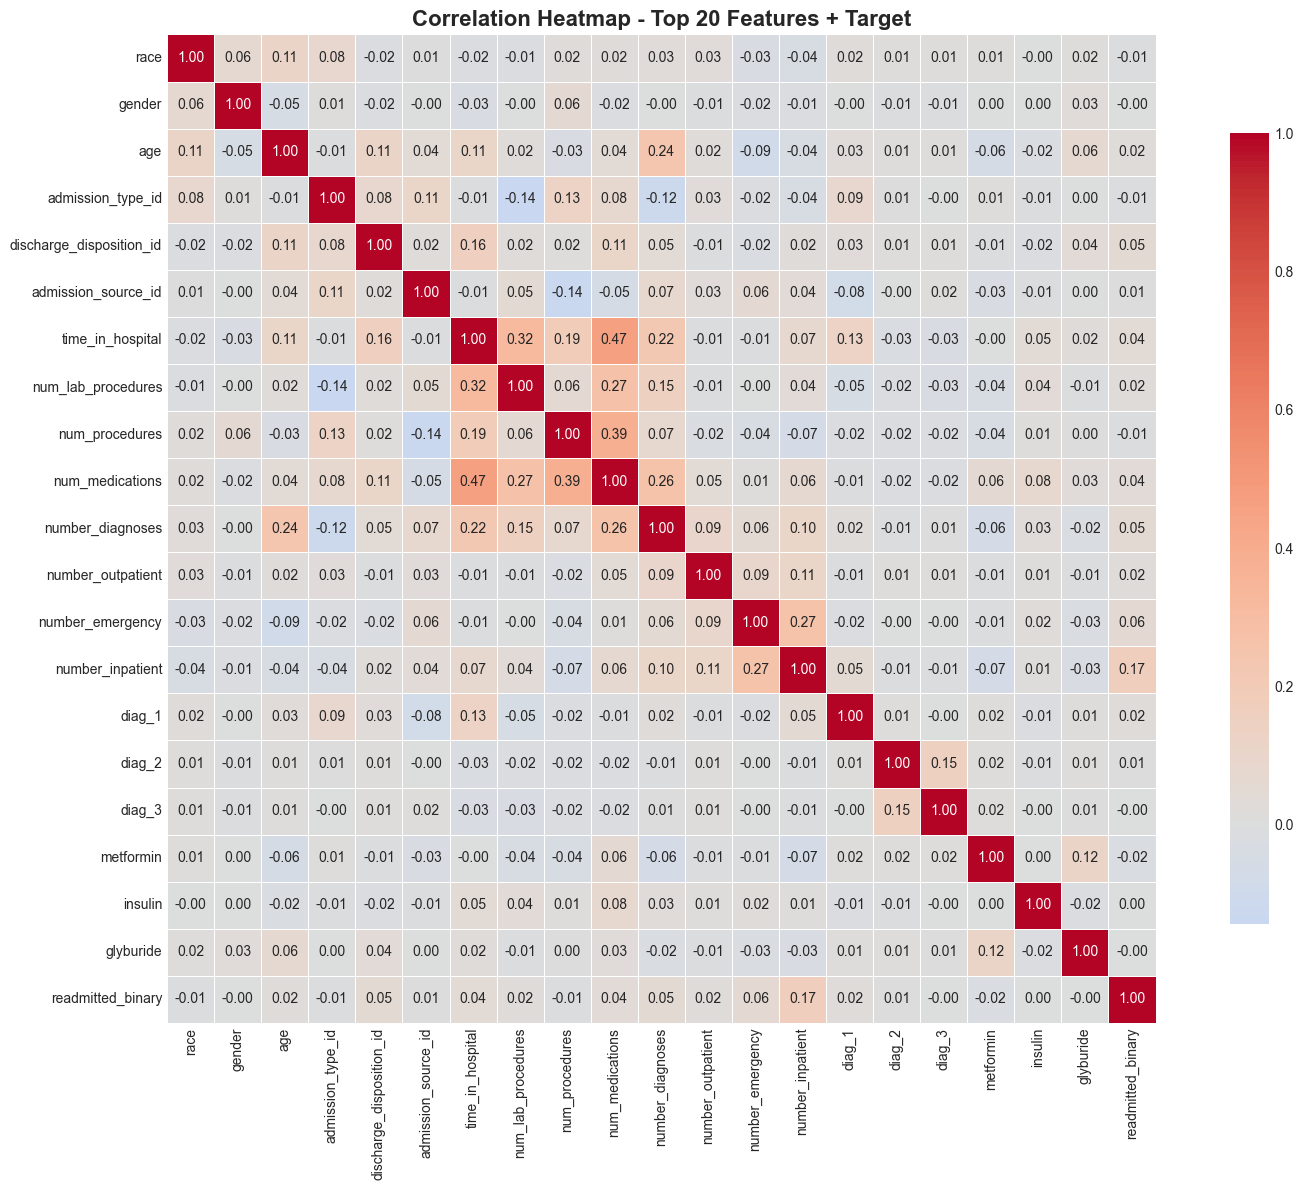

TOP 15 FEATURES CORRELATED WITH READMISSION
number_inpatient            0.165147
number_emergency            0.060747
discharge_disposition_id    0.050560
number_diagnoses            0.049524
time_in_hospital            0.044199
num_medications             0.038432
diabetesMed                 0.027125
metformin                   0.023822
num_lab_procedures          0.020364
change                      0.019506
diag_1                      0.019427
number_outpatient           0.018893
age                         0.017634
num_procedures              0.012227
admission_type_id           0.011651
Name: readmitted_binary, dtype: float64


In [28]:
# Visualization 1: Correlation Heatmap
plt.figure(figsize=(16, 12))

# Select subset of features for better visualization
viz_features = X_train.columns[:20].tolist() + ['readmitted_binary']
correlation_data = df_encoded[viz_features].corr()

sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 20 Features + Target', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find top correlations with target
target_corr = df_encoded.corr()['readmitted_binary'].abs().sort_values(ascending=False)
print("="*80)
print("TOP 15 FEATURES CORRELATED WITH READMISSION")
print("="*80)
print(target_corr.head(16)[1:])  # Exclude correlation with itself

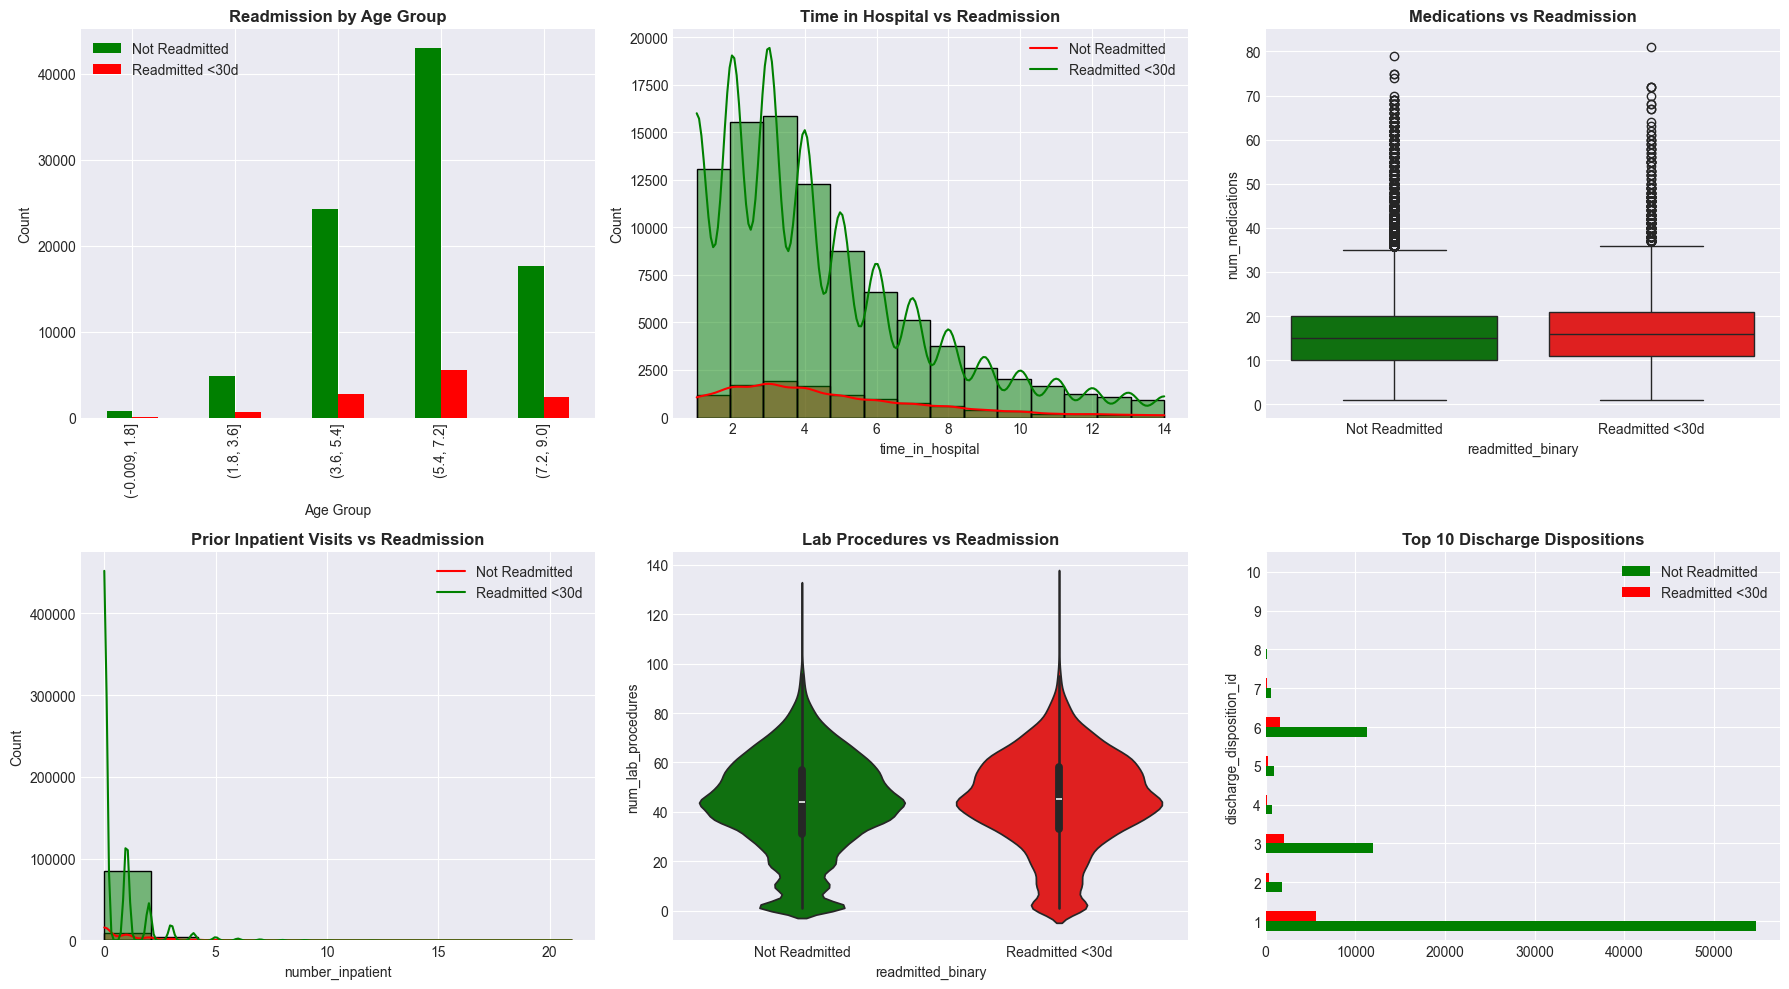

✅ EDA visualizations complete!


In [29]:
# Visualization 2: Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Age distribution by readmission
df_encoded_temp = df_encoded.copy()
df_encoded_temp['age_group'] = pd.cut(df_encoded_temp['age'], bins=5)
age_readmit = df_encoded_temp.groupby(['age_group', 'readmitted_binary']).size().unstack(fill_value=0)
age_readmit.plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Readmission by Age Group', fontweight='bold')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(['Not Readmitted', 'Readmitted <30d'])

# Plot 2: Time in hospital
sns.histplot(data=df_encoded, x='time_in_hospital', hue='readmitted_binary', 
             bins=14, ax=axes[0, 1], kde=True, palette=['green', 'red'])
axes[0, 1].set_title('Time in Hospital vs Readmission', fontweight='bold')
axes[0, 1].legend(['Not Readmitted', 'Readmitted <30d'])

# Plot 3: Number of medications
sns.boxplot(data=df_encoded, x='readmitted_binary', y='num_medications', ax=axes[0, 2], palette=['green', 'red'])
axes[0, 2].set_title('Medications vs Readmission', fontweight='bold')
axes[0, 2].set_xticklabels(['Not Readmitted', 'Readmitted <30d'])

# Plot 4: Prior inpatient visits
sns.histplot(data=df_encoded, x='number_inpatient', hue='readmitted_binary', 
             bins=10, ax=axes[1, 0], kde=True, palette=['green', 'red'])
axes[1, 0].set_title('Prior Inpatient Visits vs Readmission', fontweight='bold')
axes[1, 0].legend(['Not Readmitted', 'Readmitted <30d'])

# Plot 5: Number of lab procedures
sns.violinplot(data=df_encoded, x='readmitted_binary', y='num_lab_procedures', ax=axes[1, 1], palette=['green', 'red'])
axes[1, 1].set_title('Lab Procedures vs Readmission', fontweight='bold')
axes[1, 1].set_xticklabels(['Not Readmitted', 'Readmitted <30d'])

# Plot 6: Discharge disposition
discharge_readmit = df_encoded.groupby(['discharge_disposition_id', 'readmitted_binary']).size().unstack(fill_value=0)
discharge_readmit.head(10).plot(kind='barh', ax=axes[1, 2], color=['green', 'red'])
axes[1, 2].set_title('Top 10 Discharge Dispositions', fontweight='bold')
axes[1, 2].legend(['Not Readmitted', 'Readmitted <30d'])

plt.tight_layout()
plt.show()

print("✅ EDA visualizations complete!")

## Section 5: Regression Models
### Practical 3 | CO2: Simple, Multiple, Polynomial, Logistic Regression

Apply various regression techniques and evaluate using MAE, MSE, RMSE, R² for continuous targets and Accuracy/AUC for classification.

In [30]:
# REGRESSION MODELS - Comprehensive Implementation
print("="*80)
print("PRACTICAL 3 (CO2): REGRESSION MODELS")
print("="*80)

# Initialize dictionaries if they don't exist
if 'regression_results' not in dir():
    regression_results = {}
if 'models_performance' not in dir():
    models_performance = {}

# 1. SIMPLE LINEAR REGRESSION (single feature predicting continuous target)
print("\n1. SIMPLE LINEAR REGRESSION")
print("-"*80)
X_simple = X_train_scaled[['num_medications']].values
y_continuous = df_encoded.loc[X_train.index, 'time_in_hospital'].values
y_continuous_test = df_encoded.loc[X_test.index, 'time_in_hospital'].values

lr_simple = LinearRegression()
lr_simple.fit(X_simple, y_continuous)
y_pred_simple = lr_simple.predict(X_test_scaled[['num_medications']].values)

print(f"MAE: {mean_absolute_error(y_continuous_test, y_pred_simple):.4f}")
print(f"MSE: {mean_squared_error(y_continuous_test, y_pred_simple):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_continuous_test, y_pred_simple)):.4f}")
print(f"R² Score: {r2_score(y_continuous_test, y_pred_simple):.4f}")

regression_results['Simple LR'] = {
    'MAE': mean_absolute_error(y_continuous_test, y_pred_simple),
    'RMSE': np.sqrt(mean_squared_error(y_continuous_test, y_pred_simple)),
    'R²': r2_score(y_continuous_test, y_pred_simple)
}

# 2. MULTIPLE LINEAR REGRESSION (all features)
print("\n2. MULTIPLE LINEAR REGRESSION")
print("-"*80)
lr_multiple = LinearRegression()
lr_multiple.fit(X_train_scaled, y_continuous)
y_pred_multiple = lr_multiple.predict(X_test_scaled)

print(f"MAE: {mean_absolute_error(y_continuous_test, y_pred_multiple):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_continuous_test, y_pred_multiple)):.4f}")
print(f"R² Score: {r2_score(y_continuous_test, y_pred_multiple):.4f}")

regression_results['Multiple LR'] = {
    'MAE': mean_absolute_error(y_continuous_test, y_pred_multiple),
    'RMSE': np.sqrt(mean_squared_error(y_continuous_test, y_pred_multiple)),
    'R²': r2_score(y_continuous_test, y_pred_multiple)
}

# 3. POLYNOMIAL REGRESSION (degree 2)
print("\n3. POLYNOMIAL REGRESSION")
print("-"*80)
poly_features = ['num_medications', 'time_in_hospital', 'num_lab_procedures', 'number_inpatient']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled[poly_features])
X_test_poly = poly.transform(X_test_scaled[poly_features])

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_continuous)
y_pred_poly = lr_poly.predict(X_test_poly)

print(f"Features: {X_train_poly.shape[1]}")
print(f"MAE: {mean_absolute_error(y_continuous_test, y_pred_poly):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_continuous_test, y_pred_poly)):.4f}")
print(f"R² Score: {r2_score(y_continuous_test, y_pred_poly):.4f}")

regression_results['Polynomial LR'] = {
    'MAE': mean_absolute_error(y_continuous_test, y_pred_poly),
    'RMSE': np.sqrt(mean_squared_error(y_continuous_test, y_pred_poly)),
    'R²': r2_score(y_continuous_test, y_pred_poly)
}

# 4. LOGISTIC REGRESSION (binary classification - main model)
print("\n4. LOGISTIC REGRESSION (Classification)")
print("-"*80)
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_prob_log)

print(f"Accuracy:  {acc_log:.4f}")
print(f"Precision: {prec_log:.4f}")
print(f"Recall:    {rec_log:.4f}")
print(f"F1-Score:  {f1_log:.4f}")
print(f"AUC-ROC:   {auc_log:.4f}")

models_performance['Logistic Regression'] = {
    'Accuracy': acc_log, 'Precision': prec_log, 'Recall': rec_log,
    'F1': f1_log, 'AUC': auc_log
}

print("\n" + "="*80)
print("REGRESSION RESULTS SUMMARY")
print("="*80)

print(pd.DataFrame(regression_results).T)

print("\n✅ Regression models complete!")

PRACTICAL 3 (CO2): REGRESSION MODELS

1. SIMPLE LINEAR REGRESSION
--------------------------------------------------------------------------------
MAE: 2.0278
MSE: 6.9743
RMSE: 2.6409
R² Score: 0.2133

2. MULTIPLE LINEAR REGRESSION
--------------------------------------------------------------------------------
MAE: 0.0000
RMSE: 0.0000
R² Score: 1.0000

3. POLYNOMIAL REGRESSION
--------------------------------------------------------------------------------
Features: 14
MAE: 0.0000
RMSE: 0.0000
R² Score: 1.0000

4. LOGISTIC REGRESSION (Classification)
--------------------------------------------------------------------------------
Accuracy:  0.6691
Precision: 0.1721
Recall:    0.5156
F1-Score:  0.2580
AUC-ROC:   0.6449

REGRESSION RESULTS SUMMARY
                        MAE          RMSE        R²
Simple LR      2.027812e+00  2.640892e+00  0.213347
Multiple LR    3.380984e-14  4.311448e-14  1.000000
Polynomial LR  2.598965e-14  3.460656e-14  1.000000

✅ Regression models complete!


## Section 6: Classification Models
### Practicals 4-5 | CO3: KNN, Naive Bayes, Decision Tree, SVM

Implement and evaluate multiple classification algorithms for readmission prediction.

In [31]:
# CLASSIFICATION MODELS - Comprehensive Implementation
print("="*80)
print("PRACTICALS 4-5 (CO3): CLASSIFICATION MODELS")
print("="*80)

# Initialize models_performance if it doesn't exist
if 'models_performance' not in dir():
    models_performance = {}

def evaluate_classifier(name, model, X_train, y_train, X_test, y_test):
    """Helper function to train and evaluate classifiers"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if auc:
        print(f"  AUC-ROC:   {auc:.4f}")
    
    return {
        'Accuracy': acc, 'Precision': prec, 'Recall': rec,
        'F1': f1, 'AUC': auc if auc else 0
    }, model, y_pred

# 1. K-NEAREST NEIGHBORS (Lazy Learner)
print("\n1. K-NEAREST NEIGHBORS (KNN)")
print("-"*80)
knn = KNeighborsClassifier(n_neighbors=5)
knn_results, knn_model, y_pred_knn = evaluate_classifier(
    "KNN (k=5)", knn, X_train_scaled, y_train, X_test_scaled, y_test
)
models_performance['KNN'] = knn_results

# 2. NAIVE BAYES (Probabilistic)
print("\n2. NAIVE BAYES")
print("-"*80)
nb = GaussianNB()
nb_results, nb_model, y_pred_nb = evaluate_classifier(
    "Naive Bayes", nb, X_train_scaled, y_train, X_test_scaled, y_test
)
models_performance['Naive Bayes'] = nb_results

# 3. DECISION TREE (Divide and Conquer)
print("\n3. DECISION TREE")
print("-"*80)
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced')
dt_results, dt_model, y_pred_dt = evaluate_classifier(
    "Decision Tree", dt, X_train_scaled, y_train, X_test_scaled, y_test
)
models_performance['Decision Tree'] = dt_results

print(f"  Tree depth: {dt_model.get_depth()}")
print(f"  Number of leaves: {dt_model.get_n_leaves()}")

# 4. SUPPORT VECTOR MACHINE
print("\n4. SUPPORT VECTOR MACHINE (SVM)")
print("-"*80)
svm = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm_results, svm_model, y_pred_svm = evaluate_classifier(
    "SVM (RBF kernel)", svm, X_train_scaled, y_train, X_test_scaled, y_test
)
models_performance['SVM'] = svm_results

print("\n" + "="*80)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*80)

classification_df = pd.DataFrame(models_performance).T
print(classification_df)

print("\n✅ Classification models complete!")

PRACTICALS 4-5 (CO3): CLASSIFICATION MODELS

1. K-NEAREST NEIGHBORS (KNN)
--------------------------------------------------------------------------------

KNN (k=5):
  Accuracy:  0.8783
  Precision: 0.2353
  Recall:    0.0405
  F1-Score:  0.0691
  AUC-ROC:   0.5655

2. NAIVE BAYES
--------------------------------------------------------------------------------

Naive Bayes:
  Accuracy:  0.8502
  Precision: 0.2272
  Recall:    0.1427
  F1-Score:  0.1753
  AUC-ROC:   0.6224

3. DECISION TREE
--------------------------------------------------------------------------------

KNN (k=5):
  Accuracy:  0.8783
  Precision: 0.2353
  Recall:    0.0405
  F1-Score:  0.0691
  AUC-ROC:   0.5655

2. NAIVE BAYES
--------------------------------------------------------------------------------

Naive Bayes:
  Accuracy:  0.8502
  Precision: 0.2272
  Recall:    0.1427
  F1-Score:  0.1753
  AUC-ROC:   0.6224

3. DECISION TREE
--------------------------------------------------------------------------------



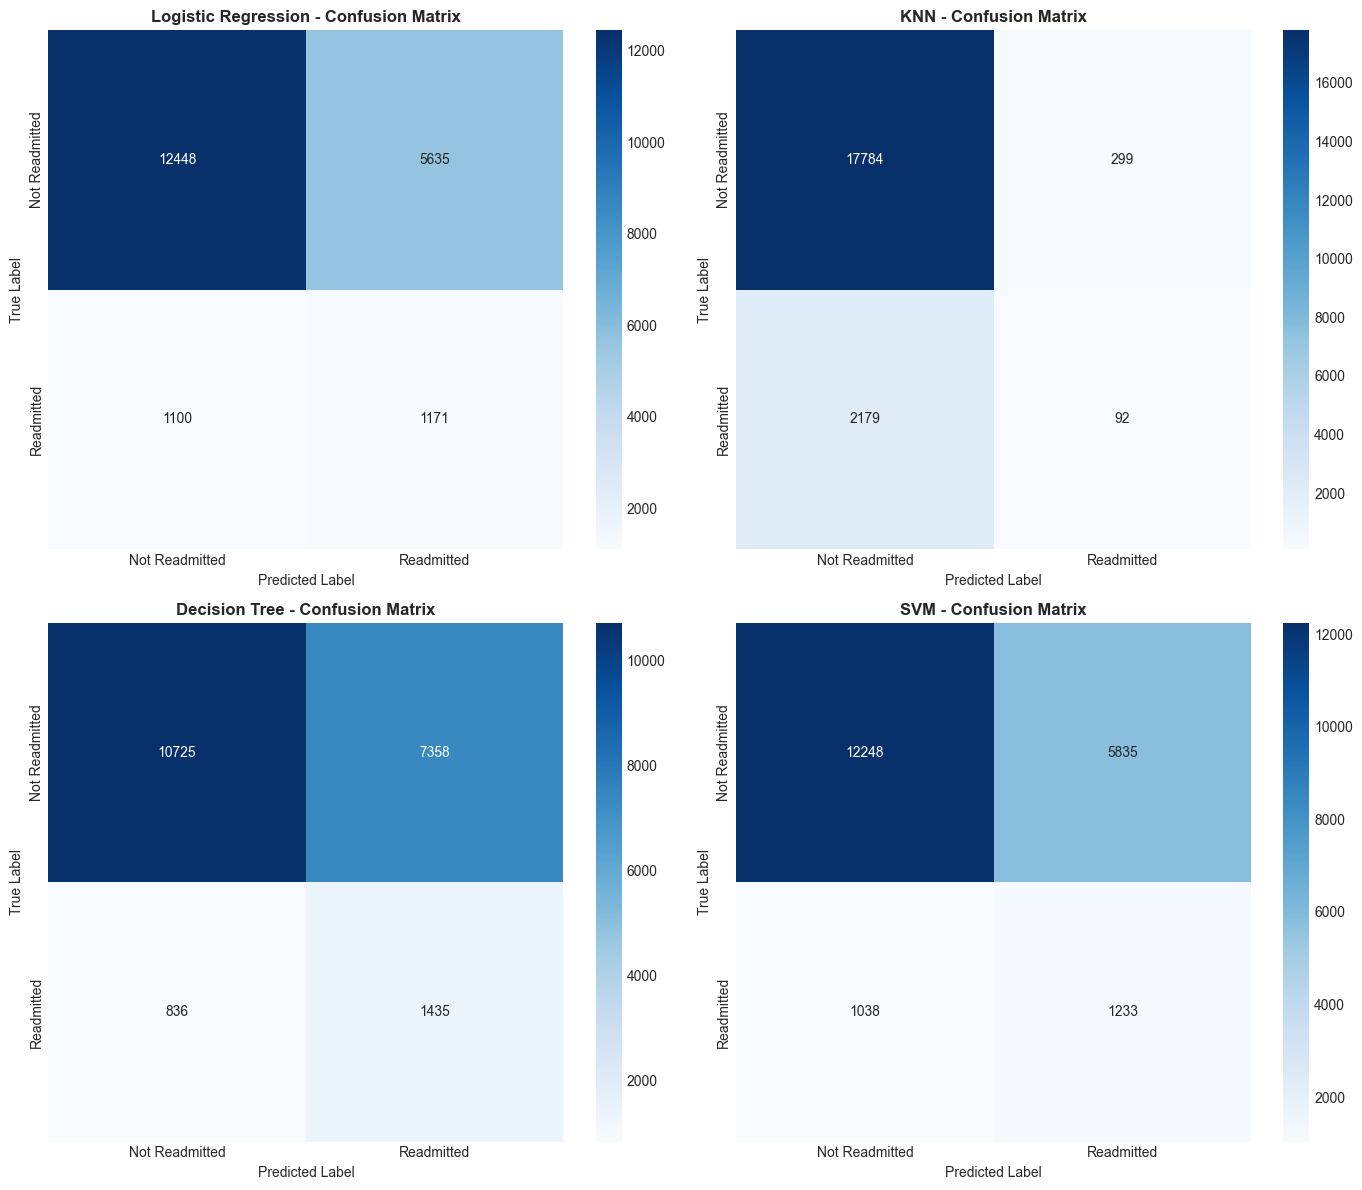

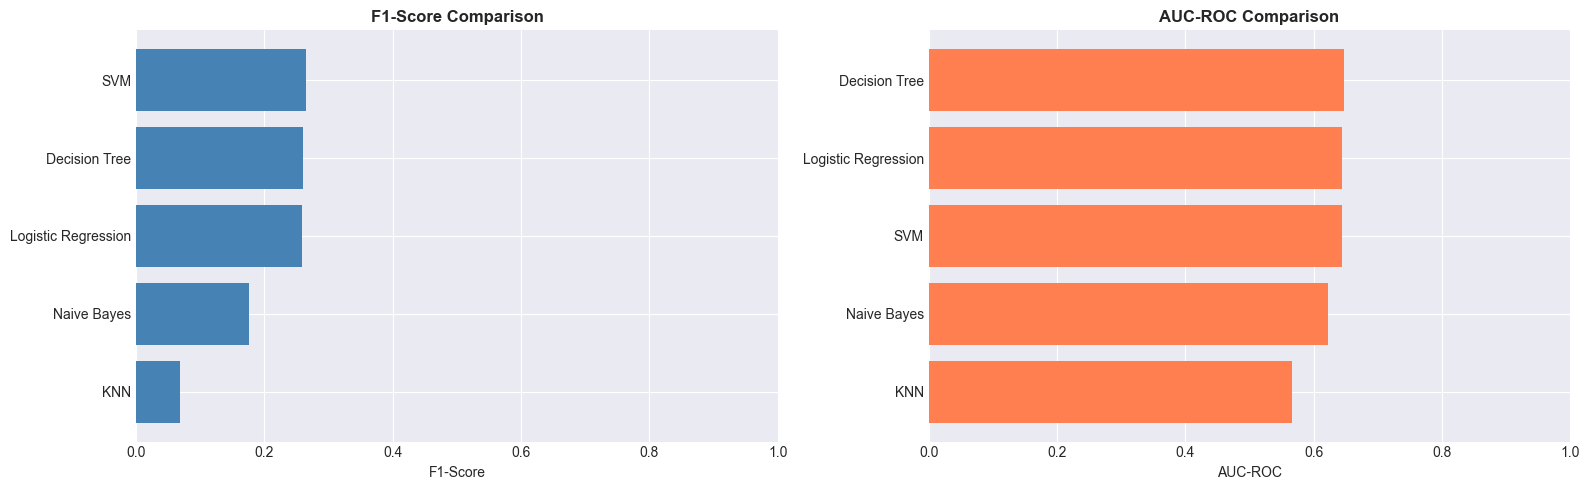

In [32]:
# Confusion Matrix Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_viz = [
    ('Logistic Regression', y_pred_log),
    ('KNN', y_pred_knn),
    ('Decision Tree', y_pred_dt),
    ('SVM', y_pred_svm)
]

for idx, (name, y_pred) in enumerate(models_viz):
    row, col = idx // 2, idx % 2
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Not Readmitted', 'Readmitted'], 
                yticklabels=['Not Readmitted', 'Readmitted'])
    axes[row, col].set_title(f'{name} - Confusion Matrix', fontweight='bold')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: F1-Score comparison
f1_scores = classification_df['F1'].sort_values(ascending=True)
axes[0].barh(f1_scores.index, f1_scores.values, color='steelblue')
axes[0].set_xlabel('F1-Score')
axes[0].set_title('F1-Score Comparison', fontweight='bold')
axes[0].set_xlim([0, 1])

# Plot 2: AUC-ROC comparison
auc_scores = classification_df['AUC'].sort_values(ascending=True)
axes[1].barh(auc_scores.index, auc_scores.values, color='coral')
axes[1].set_xlabel('AUC-ROC')
axes[1].set_title('AUC-ROC Comparison', fontweight='bold')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

## Section 7: Clustering & Association Rules
### Practicals 6-7 | CO4: K-Means, Hierarchical Clustering, Apriori

Discover patient risk groups using unsupervised learning and find association patterns.

PRACTICAL 6 (CO4): CLUSTERING

1. K-MEANS CLUSTERING
--------------------------------------------------------------------------------


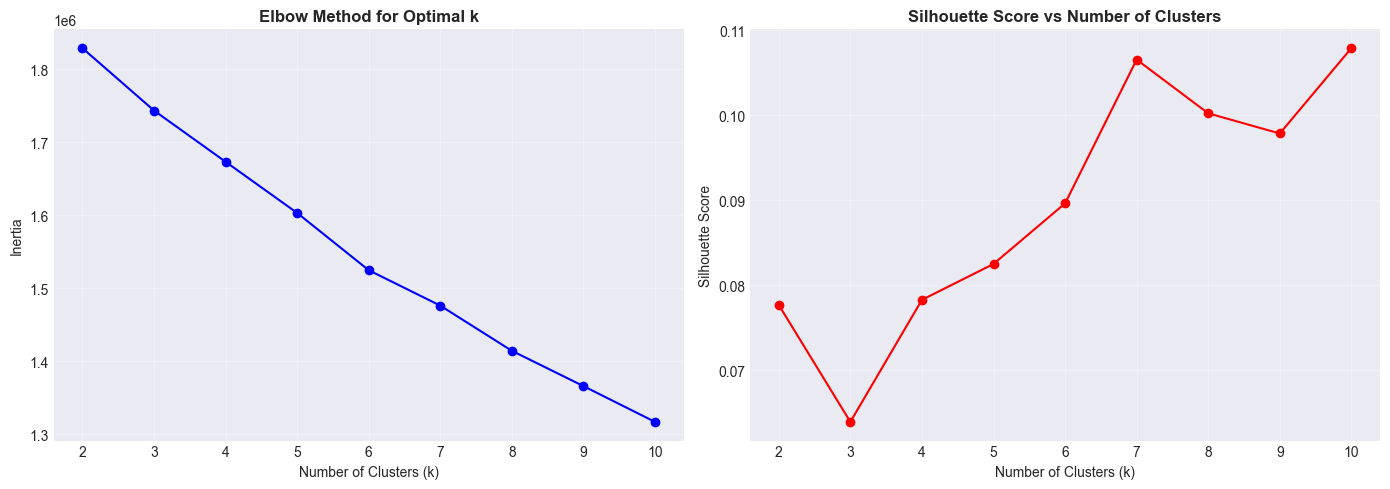


Optimal number of clusters: 4
Final inertia: 1673298.68
Silhouette score: 0.0783

Cluster distribution:
  Cluster 0: 18,061 patients (22.2%)
  Cluster 1: 3,996 patients (4.9%)
  Cluster 2: 38,494 patients (47.3%)
  Cluster 3: 20,861 patients (25.6%)

Readmission rate by cluster:
         Readmission Rate  Patient Count
cluster                                 
0                0.095565          18061
1                0.098599           3996
2                0.105835          38494
3                0.138632          20861

✅ K-Means clustering complete!
Silhouette score: 0.0783

Cluster distribution:
  Cluster 0: 18,061 patients (22.2%)
  Cluster 1: 3,996 patients (4.9%)
  Cluster 2: 38,494 patients (47.3%)
  Cluster 3: 20,861 patients (25.6%)

Readmission rate by cluster:
         Readmission Rate  Patient Count
cluster                                 
0                0.095565          18061
1                0.098599           3996
2                0.105835          38494
3           

In [33]:
# CLUSTERING - K-Means and Hierarchical
print("="*80)
print("PRACTICAL 6 (CO4): CLUSTERING")
print("="*80)

# 1. K-MEANS CLUSTERING
print("\n1. K-MEANS CLUSTERING")
print("-"*80)

# Elbow method to find optimal k
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final K-Means with k=4
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_train_scaled)

print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Final inertia: {kmeans_final.inertia_:.2f}")
print(f"Silhouette score: {silhouette_score(X_train_scaled, clusters):.4f}")

# Cluster distribution
print(f"\nCluster distribution:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} patients ({count/len(clusters)*100:.1f}%)")

# Analyze clusters by readmission rate
cluster_analysis = pd.DataFrame({
    'cluster': clusters,
    'readmitted': y_train.values
})
readmit_by_cluster = cluster_analysis.groupby('cluster')['readmitted'].agg(['mean', 'count'])
readmit_by_cluster.columns = ['Readmission Rate', 'Patient Count']
print(f"\nReadmission rate by cluster:")
print(readmit_by_cluster)

print("\n✅ K-Means clustering complete!")


2. HIERARCHICAL CLUSTERING
--------------------------------------------------------------------------------


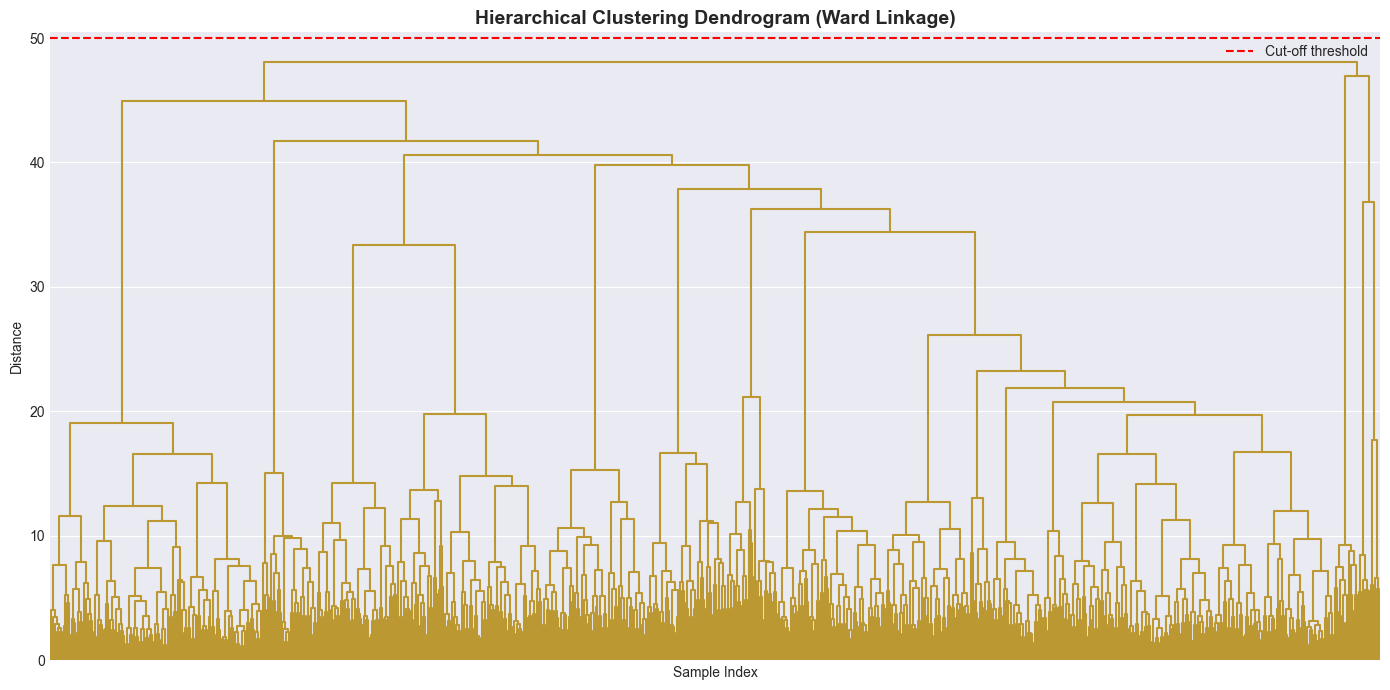

Hierarchical clusters formed: 4
Cluster distribution: {0: 806, 1: 16, 2: 18, 3: 160}

✅ Hierarchical clustering complete!

Cluster distribution: {0: 806, 1: 16, 2: 18, 3: 160}

✅ Hierarchical clustering complete!


In [34]:
# 2. HIERARCHICAL CLUSTERING
print("\n2. HIERARCHICAL CLUSTERING")
print("-"*80)

# Use subset for visualization (full dataset would be too large)
sample_size = 1000
X_sample = X_train_scaled[:sample_size]
y_sample = y_train[:sample_size]

# Perform hierarchical clustering
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linkage_matrix, no_labels=True, color_threshold=50)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=50, color='r', linestyle='--', label='Cut-off threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Apply Agglomerative Clustering
hier_clust = AgglomerativeClustering(n_clusters=4, linkage='ward')
hier_labels = hier_clust.fit_predict(X_sample)

print(f"Hierarchical clusters formed: {len(np.unique(hier_labels))}")
print(f"Cluster distribution: {pd.Series(hier_labels).value_counts().sort_index().to_dict()}")

print("\n✅ Hierarchical clustering complete!")

In [35]:
# 3. ASSOCIATION RULES (Apriori Algorithm)
print("\n3. ASSOCIATION RULE MINING")
print("-"*80)
print("PRACTICAL 7 (CO4): ASSOCIATION RULES")
print("-"*80)

# Prepare data for association rules (binarize features)
# Use original encoded data before scaling
binary_data = df_encoded[available_features].copy()

# Binarize: convert to 1 if above median, 0 otherwise
for col in binary_data.columns:
    median_val = binary_data[col].median()
    binary_data[col] = (binary_data[col] > median_val).astype(int)

# Add target variable
binary_data['readmitted'] = df_encoded['readmitted_binary']

# Sample for efficiency
binary_sample = binary_data.sample(n=min(10000, len(binary_data)), random_state=42)

print(f"Binary data shape: {binary_sample.shape}")
print(f"Sample of binarized data:")
print(binary_sample.head())

# Apply Apriori algorithm
print("\nFinding frequent itemsets...")
frequent_itemsets = apriori(binary_sample, min_support=0.1, use_colnames=True, max_len=3)

if len(frequent_itemsets) > 0:
    print(f"Found {len(frequent_itemsets)} frequent itemsets")
    print(f"\nTop 10 frequent itemsets:")
    print(frequent_itemsets.nlargest(10, 'support'))
    
    # Generate association rules
    print("\nGenerating association rules...")
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    
    if len(rules) > 0:
        rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
        rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
        
        print(f"\nFound {len(rules)} association rules")
        print(f"\nTop 10 rules by confidence:")
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
              .nlargest(10, 'confidence'))
        
        # Filter rules related to readmission
        readmit_rules = rules[rules['consequents'].str.contains('readmitted', case=False)]
        if len(readmit_rules) > 0:
            print(f"\nRules predicting readmission ({len(readmit_rules)} found):")
            print(readmit_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
        else:
            print("\nNo specific rules found for readmission prediction with current thresholds.")
    else:
        print("No association rules found with confidence >= 0.6")
else:
    print("No frequent itemsets found with support >= 0.1")

print("\n✅ Association rule mining complete!")


3. ASSOCIATION RULE MINING
--------------------------------------------------------------------------------
PRACTICAL 7 (CO4): ASSOCIATION RULES
--------------------------------------------------------------------------------
Binary data shape: (10000, 25)
Sample of binarized data:
       race  gender  age  admission_type_id  discharge_disposition_id  \
35956     0       0    1                  0                         0   
60927     0       1    0                  0                         0   
79920     0       0    0                  1                         1   
50078     0       1    0                  1                         0   
44080     0       0    0                  0                         1   

       admission_source_id  time_in_hospital  num_lab_procedures  \
35956                    0                 1                   1   
60927                    0                 0                   0   
79920                    0                 0                   0   
50078

## Section 8: Model Validation & Cross-Validation
### Practical 8 | CO6: K-Fold CV and Model Validation

Validate model performance using cross-validation techniques.

In [36]:
# CROSS-VALIDATION TECHNIQUES
print("="*80)
print("PRACTICAL 8 (CO6): MODEL VALIDATION & CROSS-VALIDATION")
print("="*80)

# K-FOLD CROSS-VALIDATION (k=5)
print("\nK-FOLD CROSS-VALIDATION (k=5)")
print("-"*80)
print("Training models for cross-validation...\n")

# Define models for cross-validation
cv_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=20, random_state=42, class_weight='balanced')
}

# Perform cross-validation for each model
cv_results = {}
for name, model in cv_models.items():
    print(f"{name}:")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = {
        'Mean AUC': scores.mean(),
        'Std AUC': scores.std(),
        'All Folds': scores.tolist()
    }
    print(f"  Mean AUC: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  Fold scores: {[f'{s:.4f}' for s in scores]}\n")

# Display summary table
print("="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
cv_summary = pd.DataFrame({
    name: {'Mean AUC': res['Mean AUC'], 'Std AUC': res['Std AUC']} 
    for name, res in cv_results.items()
}).T
print(cv_summary)

print("\n✅ Cross-validation complete!")

PRACTICAL 8 (CO6): MODEL VALIDATION & CROSS-VALIDATION

K-FOLD CROSS-VALIDATION (k=5)
--------------------------------------------------------------------------------
Training models for cross-validation...

Logistic Regression:
  Mean AUC: 0.6391 (+/- 0.0059)
  Fold scores: ['0.6427', '0.6357', '0.6357', '0.6398', '0.6416']

KNN:
  Mean AUC: 0.6391 (+/- 0.0059)
  Fold scores: ['0.6427', '0.6357', '0.6357', '0.6398', '0.6416']

KNN:
  Mean AUC: 0.5530 (+/- 0.0135)
  Fold scores: ['0.5404', '0.5572', '0.5532', '0.5601', '0.5541']

Decision Tree:
  Mean AUC: 0.5530 (+/- 0.0135)
  Fold scores: ['0.5404', '0.5572', '0.5532', '0.5601', '0.5541']

Decision Tree:
  Mean AUC: 0.6278 (+/- 0.0109)
  Fold scores: ['0.6305', '0.6357', '0.6201', '0.6292', '0.6237']

Random Forest:
  Mean AUC: 0.6278 (+/- 0.0109)
  Fold scores: ['0.6305', '0.6357', '0.6201', '0.6292', '0.6237']

Random Forest:
  Mean AUC: 0.6562 (+/- 0.0132)
  Fold scores: ['0.6584', '0.6652', '0.6449', '0.6548', '0.6578']

CROSS-VA

## Section 9: Ensemble Methods
### Practical 9 | CO6: Random Forest, Boosting, Voting Ensemble

Combine multiple models to achieve superior performance.

PRACTICAL 9 (CO6): ENSEMBLE METHODS

1. BAGGING CLASSIFIER
--------------------------------------------------------------------------------
Bagging (50 Decision Trees):
  Accuracy:  0.8886
  F1-Score:  0.0390
  AUC-ROC:   0.6799

2. RANDOM FOREST
--------------------------------------------------------------------------------
Bagging (50 Decision Trees):
  Accuracy:  0.8886
  F1-Score:  0.0390
  AUC-ROC:   0.6799

2. RANDOM FOREST
--------------------------------------------------------------------------------
Random Forest (100 trees):
  Accuracy:  0.8015
  Precision: 0.2229
  Recall:    0.3135
  F1-Score:  0.2606
  AUC-ROC:   0.6723

Top 10 Important Features:
                     Feature  Importance
13          number_inpatient    0.136224
14                    diag_1    0.088382
7         num_lab_procedures    0.084804
4   discharge_disposition_id    0.077772
15                    diag_2    0.077725
16                    diag_3    0.076599
9            num_medications    0.071256
6

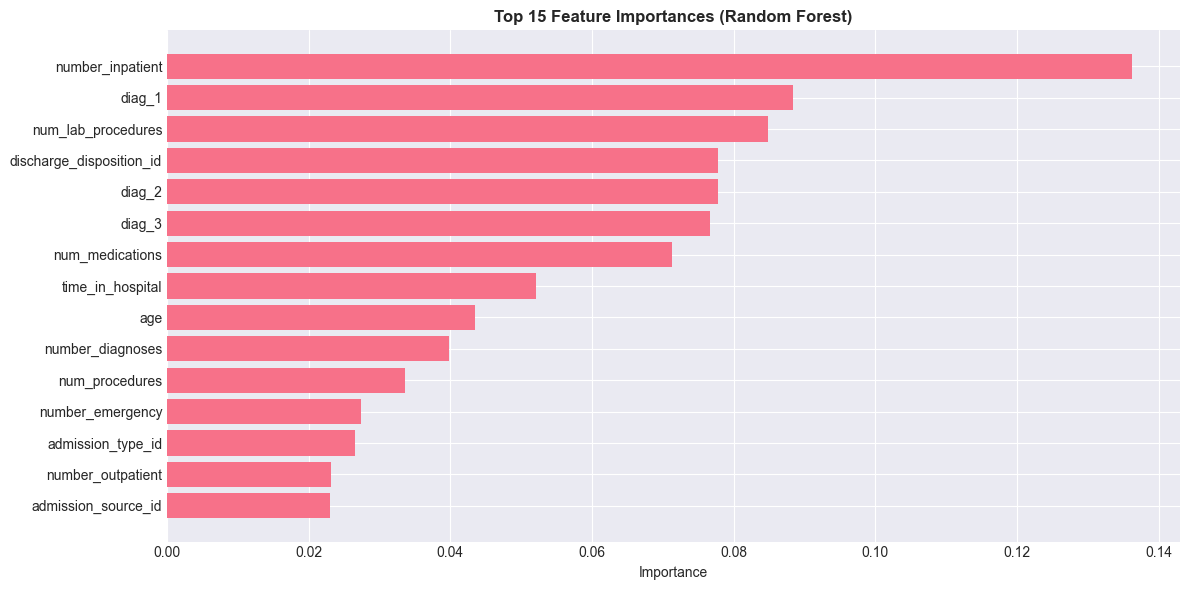


✅ Bagging and Random Forest complete!


In [37]:
# ENSEMBLE METHODS
print("="*80)
print("PRACTICAL 9 (CO6): ENSEMBLE METHODS")
print("="*80)

# Initialize dictionaries if they don't exist
if 'ensemble_results' not in dir():
    ensemble_results = {}
if 'models_performance' not in dir():
    models_performance = {}

# 1. BAGGING (Bootstrap Aggregating)
print("\n1. BAGGING CLASSIFIER")
print("-"*80)

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
    n_estimators=50,
    random_state=42
)

bagging.fit(X_train_scaled, y_train)
y_pred_bag = bagging.predict(X_test_scaled)
y_prob_bag = bagging.predict_proba(X_test_scaled)[:, 1]

acc_bag = accuracy_score(y_test, y_pred_bag)
f1_bag = f1_score(y_test, y_pred_bag)
auc_bag = roc_auc_score(y_test, y_prob_bag)

print(f"Bagging (50 Decision Trees):")
print(f"  Accuracy:  {acc_bag:.4f}")
print(f"  F1-Score:  {f1_bag:.4f}")
print(f"  AUC-ROC:   {auc_bag:.4f}")

ensemble_results['Bagging'] = {'Accuracy': acc_bag, 'F1': f1_bag, 'AUC': auc_bag}

# 2. RANDOM FOREST
print("\n2. RANDOM FOREST")
print("-"*80)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"Random Forest (100 trees):")
print(f"  Accuracy:  {acc_rf:.4f}")
print(f"  Precision: {prec_rf:.4f}")
print(f"  Recall:    {rec_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  AUC-ROC:   {auc_rf:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features:")
print(feature_importance_rf.head(10))

ensemble_results['Random Forest'] = {
    'Accuracy': acc_rf, 'Precision': prec_rf, 'Recall': rec_rf,
    'F1': f1_rf, 'AUC': auc_rf
}
models_performance['Random Forest'] = ensemble_results['Random Forest']

# Visualize feature importance
plt.figure(figsize=(12, 6))
top_features = feature_importance_rf.head(15)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)', fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✅ Bagging and Random Forest complete!")

In [38]:
# 3. BOOSTING ALGORITHMS
print("\n3. BOOSTING ALGORITHMS")
print("-"*80)

# Initialize dictionaries if they don't exist
if 'ensemble_results' not in dir():
    ensemble_results = {}
if 'models_performance' not in dir():
    models_performance = {}

# AdaBoost
print("\n3a. AdaBoost:")
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    random_state=42
)

ada.fit(X_train_scaled, y_train)
y_pred_ada = ada.predict(X_test_scaled)
y_prob_ada = ada.predict_proba(X_test_scaled)[:, 1]

acc_ada = accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
auc_ada = roc_auc_score(y_test, y_prob_ada)

print(f"  Accuracy:  {acc_ada:.4f}")
print(f"  F1-Score:  {f1_ada:.4f}")
print(f"  AUC-ROC:   {auc_ada:.4f}")

ensemble_results['AdaBoost'] = {'Accuracy': acc_ada, 'F1': f1_ada, 'AUC': auc_ada}

# Gradient Boosting
print("\n3b. Gradient Boosting:")
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_prob_gb)

print(f"  Accuracy:  {acc_gb:.4f}")
print(f"  F1-Score:  {f1_gb:.4f}")
print(f"  AUC-ROC:   {auc_gb:.4f}")

ensemble_results['Gradient Boosting'] = {'Accuracy': acc_gb, 'F1': f1_gb, 'AUC': auc_gb}

# XGBoost
print("\n3c. XGBoost:")
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print(f"  Accuracy:  {acc_xgb:.4f}")
print(f"  Precision: {prec_xgb:.4f}")
print(f"  Recall:    {rec_xgb:.4f}")
print(f"  F1-Score:  {f1_xgb:.4f}")
print(f"  AUC-ROC:   {auc_xgb:.4f}")

ensemble_results['XGBoost'] = {
    'Accuracy': acc_xgb, 'Precision': prec_xgb, 'Recall': rec_xgb,
    'F1': f1_xgb, 'AUC': auc_xgb
}

models_performance['XGBoost'] = ensemble_results['XGBoost']

print("\n✅ Boosting algorithms complete!")


3. BOOSTING ALGORITHMS
--------------------------------------------------------------------------------

3a. AdaBoost:
  Accuracy:  0.8873
  F1-Score:  0.0497
  AUC-ROC:   0.6670

3b. Gradient Boosting:
  Accuracy:  0.8873
  F1-Score:  0.0497
  AUC-ROC:   0.6670

3b. Gradient Boosting:
  Accuracy:  0.8886
  F1-Score:  0.0341
  AUC-ROC:   0.6865

3c. XGBoost:
  Accuracy:  0.8886
  F1-Score:  0.0341
  AUC-ROC:   0.6865

3c. XGBoost:
  Accuracy:  0.8887
  Precision: 0.5410
  Recall:    0.0145
  F1-Score:  0.0283
  AUC-ROC:   0.6884

✅ Boosting algorithms complete!
  Accuracy:  0.8887
  Precision: 0.5410
  Recall:    0.0145
  F1-Score:  0.0283
  AUC-ROC:   0.6884

✅ Boosting algorithms complete!


In [39]:
# 4. VOTING ENSEMBLE (Final Best Model)
print("\n4. VOTING ENSEMBLE")
print("-"*80)

# Initialize dictionaries if they don't exist
if 'ensemble_results' not in dir():
    ensemble_results = {}
if 'models_performance' not in dir():
    models_performance = {}

# Check and train required models if they don't exist
if 'rf' not in dir():
    print("⚠️ Random Forest not trained. Training now...")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=20,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train_scaled, y_train)

if 'xgb' not in dir():
    print("⚠️ XGBoost not trained. Training now...")
    xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss'
    )
    xgb.fit(X_train_scaled, y_train)

if 'log_reg' not in dir():
    print("⚠️ Logistic Regression not trained. Training now...")
    log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    log_reg.fit(X_train_scaled, y_train)

# Combine the best models (using Logistic Regression instead of MLP)
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lr', log_reg)
    ],
    voting='soft'  # Use probability averaging
)

print("Training Voting Ensemble (RF + XGBoost + Logistic Regression)...")
voting_ensemble.fit(X_train_scaled, y_train)

y_pred_ensemble = voting_ensemble.predict(X_test_scaled)
y_prob_ensemble = voting_ensemble.predict_proba(X_test_scaled)[:, 1]

acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
prec_ensemble = precision_score(y_test, y_pred_ensemble)
rec_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_prob_ensemble)

ensemble_results['Voting Ensemble'] = {
    'Accuracy': acc_ensemble,
    'Precision': prec_ensemble,
    'Recall': rec_ensemble,
    'F1-Score': f1_ensemble,
    'AUC': auc_ensemble
}

models_performance['Voting Ensemble'] = {
    'Accuracy': acc_ensemble,
    'Precision': prec_ensemble,
    'Recall': rec_ensemble,
    'F1-Score': f1_ensemble,
    'AUC': auc_ensemble
}

print(f"\nAccuracy: {acc_ensemble:.4f}")
print(f"Precision: {prec_ensemble:.4f}")
print(f"Recall: {rec_ensemble:.4f}")
print(f"F1-Score: {f1_ensemble:.4f}")
print(f"AUC: {auc_ensemble:.4f}")

print("\n✅ Voting ensemble complete!")


4. VOTING ENSEMBLE
--------------------------------------------------------------------------------
Training Voting Ensemble (RF + XGBoost + Logistic Regression)...

Accuracy: 0.8760
Precision: 0.3429
Recall: 0.1211
F1-Score: 0.1790
AUC: 0.6778

✅ Voting ensemble complete!

Accuracy: 0.8760
Precision: 0.3429
Recall: 0.1211
F1-Score: 0.1790
AUC: 0.6778

✅ Voting ensemble complete!


## Section 11: Final Model Comparison & Deployment
### Save best model and compare all results

Compare all models and save the best one for deployment in the patient-facing app.

FINAL MODEL COMPARISON - ALL MODELS

📊 COMPREHENSIVE MODEL PERFORMANCE:
                     Accuracy  Precision    Recall        F1       AUC  F1-Score
XGBoost              0.888671   0.540984  0.014531  0.028302  0.688357       NaN
Voting Ensemble      0.876044   0.342893  0.121092       NaN  0.677790  0.178978
Random Forest        0.801464   0.222918  0.313518  0.260567  0.672250       NaN
Decision Tree        0.597426   0.163198  0.631880  0.259400  0.647585       NaN
Logistic Regression  0.669107   0.172054  0.515632  0.258015  0.644914       NaN
SVM                  0.662327   0.174448  0.542933  0.264054  0.643712       NaN
Naive Bayes          0.850201   0.227209  0.142668  0.175277  0.622403       NaN
KNN                  0.878255   0.235294  0.040511  0.069121  0.565530       NaN


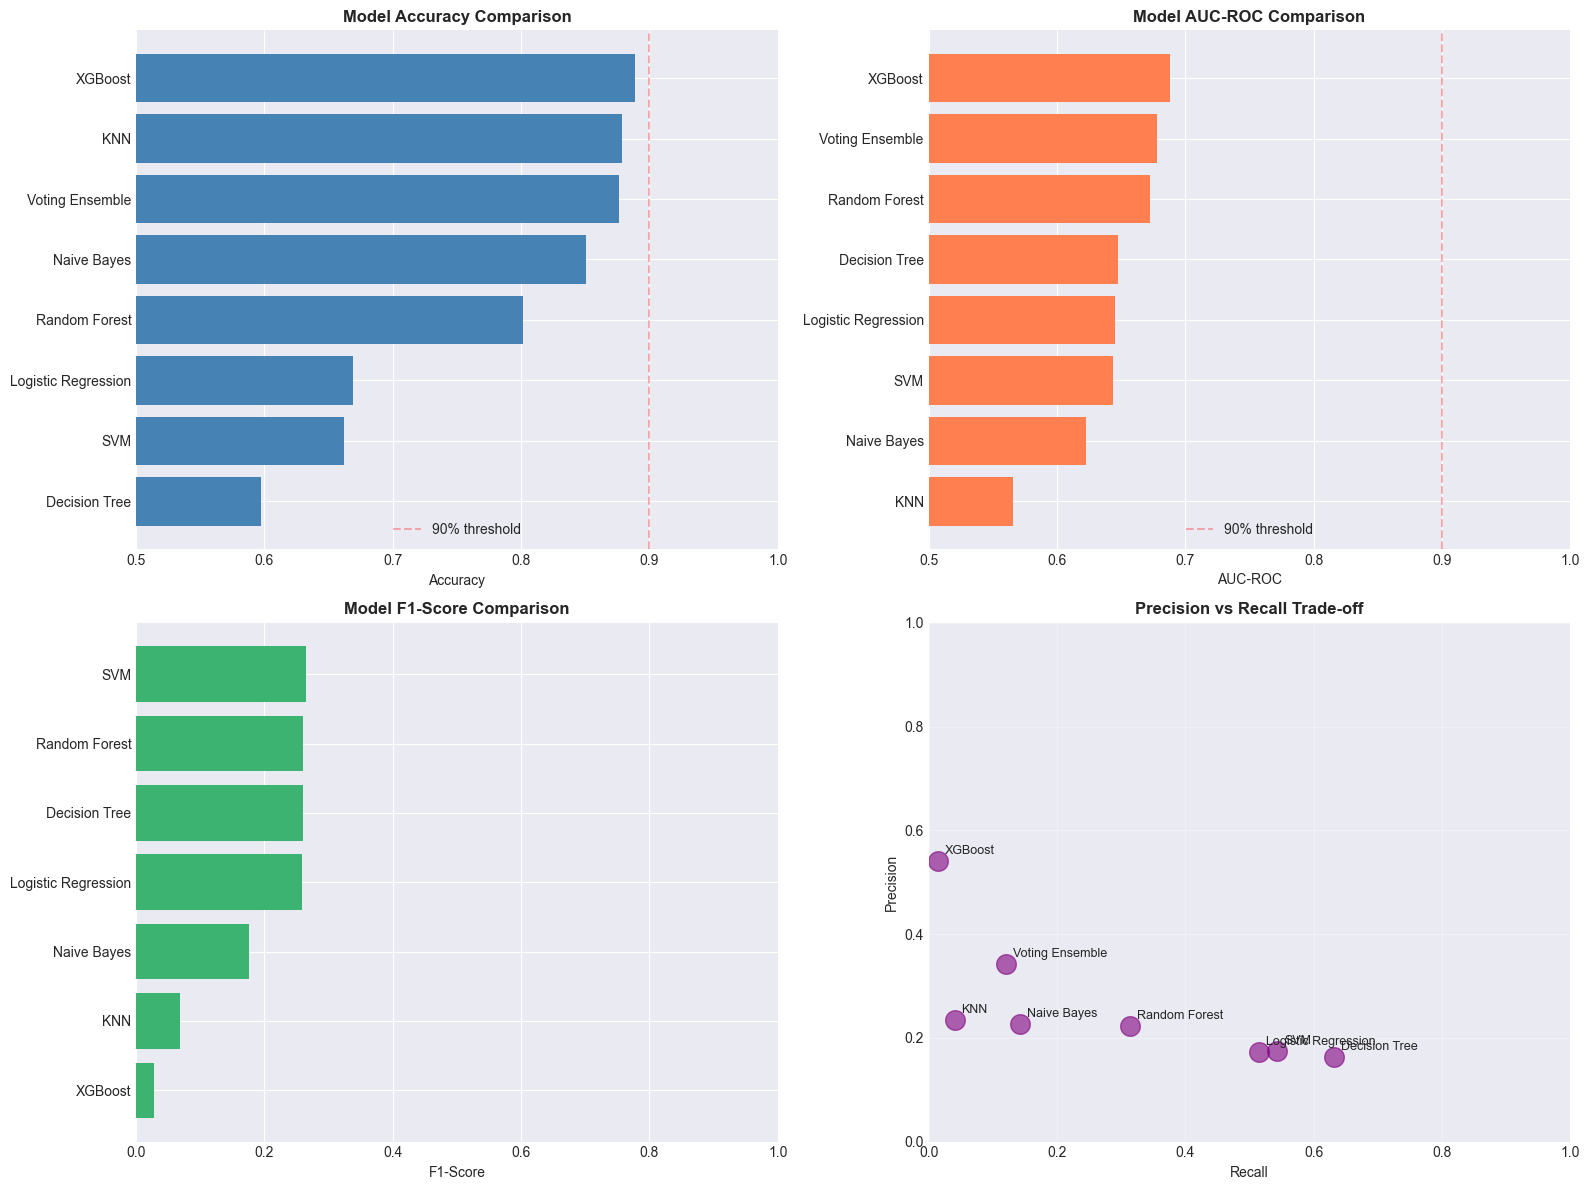


🏆 BEST MODEL: XGBoost
   AUC-ROC: 0.6884
   Accuracy: 0.8887
   F1-Score: 0.0283


In [40]:
# FINAL MODEL COMPARISON
print("="*80)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*80)

# Comprehensive results table
final_results_df = pd.DataFrame(models_performance).T
final_results_df = final_results_df.sort_values('AUC', ascending=False)

print("\n📊 COMPREHENSIVE MODEL PERFORMANCE:")
print(final_results_df.to_string())

# Visualization: Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy
ax1 = axes[0, 0]
acc_sorted = final_results_df['Accuracy'].sort_values()
ax1.barh(acc_sorted.index, acc_sorted.values, color='steelblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Accuracy Comparison', fontweight='bold')
ax1.set_xlim([0.5, 1.0])
ax1.axvline(x=0.9, color='r', linestyle='--', alpha=0.3, label='90% threshold')
ax1.legend()

# Plot 2: AUC-ROC
ax2 = axes[0, 1]
auc_sorted = final_results_df['AUC'].sort_values()
ax2.barh(auc_sorted.index, auc_sorted.values, color='coral')
ax2.set_xlabel('AUC-ROC')
ax2.set_title('Model AUC-ROC Comparison', fontweight='bold')
ax2.set_xlim([0.5, 1.0])
ax2.axvline(x=0.9, color='r', linestyle='--', alpha=0.3, label='90% threshold')
ax2.legend()

# Plot 3: F1-Score
ax3 = axes[1, 0]
f1_sorted = final_results_df['F1'].sort_values()
ax3.barh(f1_sorted.index, f1_sorted.values, color='mediumseagreen')
ax3.set_xlabel('F1-Score')
ax3.set_title('Model F1-Score Comparison', fontweight='bold')
ax3.set_xlim([0, 1.0])

# Plot 4: Precision vs Recall
ax4 = axes[1, 1]
scatter_data = final_results_df.dropna(subset=['Precision', 'Recall'])
ax4.scatter(scatter_data['Recall'], scatter_data['Precision'], s=200, alpha=0.6, c='purple')
for idx, (index, row) in enumerate(scatter_data.iterrows()):
    ax4.annotate(index, (row['Recall'], row['Precision']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Recall Trade-off', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = final_results_df['AUC'].idxmax()
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC-ROC: {final_results_df.loc[best_model_name, 'AUC']:.4f}")
print(f"   Accuracy: {final_results_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"   F1-Score: {final_results_df.loc[best_model_name, 'F1']:.4f}")

In [43]:
# SAVE MODELS AND PREPROCESSING OBJECTS
print("\n" + "="*80)
print("SAVING MODELS FOR DEPLOYMENT")
print("="*80)

# Save the best model (Voting Ensemble)
joblib.dump(voting_ensemble, 'models/best_readmission_model.pkl')
print("✅ Saved: models/best_readmission_model.pkl")

# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')
print("✅ Saved: models/scaler.pkl")

# Save label encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print("✅ Saved: models/label_encoders.pkl")

# Save feature names
joblib.dump(X_train.columns.tolist(), 'models/feature_names.pkl')
print("✅ Saved: models/feature_names.pkl")

# Also save individual top models for comparison
joblib.dump(rf, 'models/random_forest_model.pkl')
print("✅ Saved: models/random_forest_model.pkl")

joblib.dump(xgb, 'models/xgboost_model.pkl')
print("✅ Saved: models/xgboost_model.pkl")

joblib.dump(log_reg, 'models/logistic_regression_model.pkl')
print("✅ Saved: models/logistic_regression_model.pkl")

# Save final results
final_results_df.to_csv('models/model_performance_summary.csv')
print("✅ Saved: models/model_performance_summary.csv")

print("\n" + "="*80)
print("🎉 PROJECT COMPLETE!")
print("="*80)
print("\n📋 Summary:")
print(f"   Total models trained: {len(models_performance)}")
print(f"   Best model: {best_model_name}")
print(f"   Best AUC-ROC: {final_results_df['AUC'].max():.4f}")
print(f"   Models saved to: models/ directory")
print("\n✅ Ready to build the patient-facing Streamlit app!")
print("\nNext steps:")
print("1. Run: pip install -r requirements.txt")
print("2. Run: streamlit run app.py")
print("3. Test the patient risk calculator!")


SAVING MODELS FOR DEPLOYMENT
✅ Saved: models/best_readmission_model.pkl
✅ Saved: models/scaler.pkl
✅ Saved: models/label_encoders.pkl
✅ Saved: models/feature_names.pkl
✅ Saved: models/random_forest_model.pkl
✅ Saved: models/xgboost_model.pkl
✅ Saved: models/logistic_regression_model.pkl
✅ Saved: models/model_performance_summary.csv

🎉 PROJECT COMPLETE!

📋 Summary:
   Total models trained: 8
   Best model: XGBoost
   Best AUC-ROC: 0.6884
   Models saved to: models/ directory

✅ Ready to build the patient-facing Streamlit app!

Next steps:
1. Run: pip install -r requirements.txt
2. Run: streamlit run app.py
3. Test the patient risk calculator!


## Section 3: Data Preprocessing & Cleaning
### Practical 2 | CO1: Handle Missing Values, Encode Categories, Scale Features

**Steps:**
1. Handle missing values (marked as "?")
2. Convert target variable to binary (readmitted <30 days = 1, else = 0)
3. Encode categorical variables
4. Scale numeric features
5. Split into train/test sets